In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git
! git clone https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 1002, done.
remote: Counting objects: 100% (677/677), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 1002 (delta 367), reused 542 (delta 249), pack-reused 325
Receiving objects: 100% (1002/1002), 29.20 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (466/466), done.
Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1519 (delta 223), reused 220 (delta 212), pack-reused 1264
Receiving objects: 100% (1519/1519), 50.33 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (909/909), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import gc
import scipy.sparse as sps

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature

from catboost import CatBoostClassifier

In [4]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

# behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
# history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

# behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
# history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

# Topic Model

In [21]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=20)
topics = lda_model.fit_transform(titles_bow)

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
topics_projected_2d = tsne.fit_transform(topics)

tsne = TSNE(n_components=3)
topics_projected_3d = tsne.fit_transform(topics)

<Axes: >

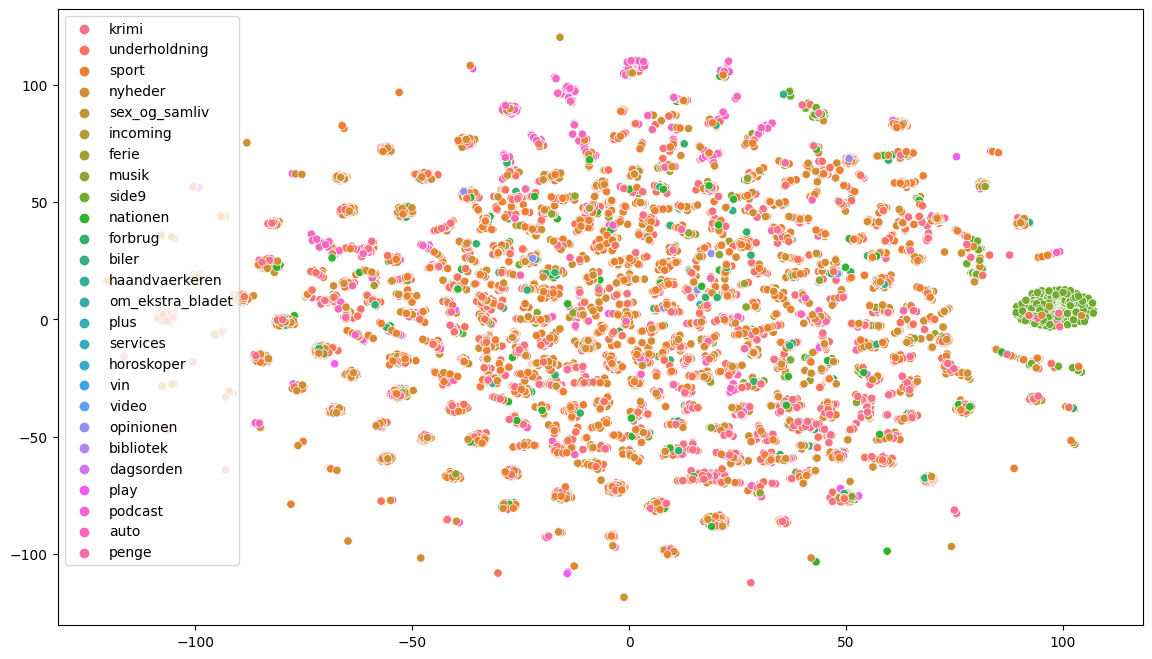

In [24]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.scatterplot(x=topics_projected_2d[:, 0], y=topics_projected_2d[:, 1], hue=articles['category_str'].to_numpy())

<Axes: >

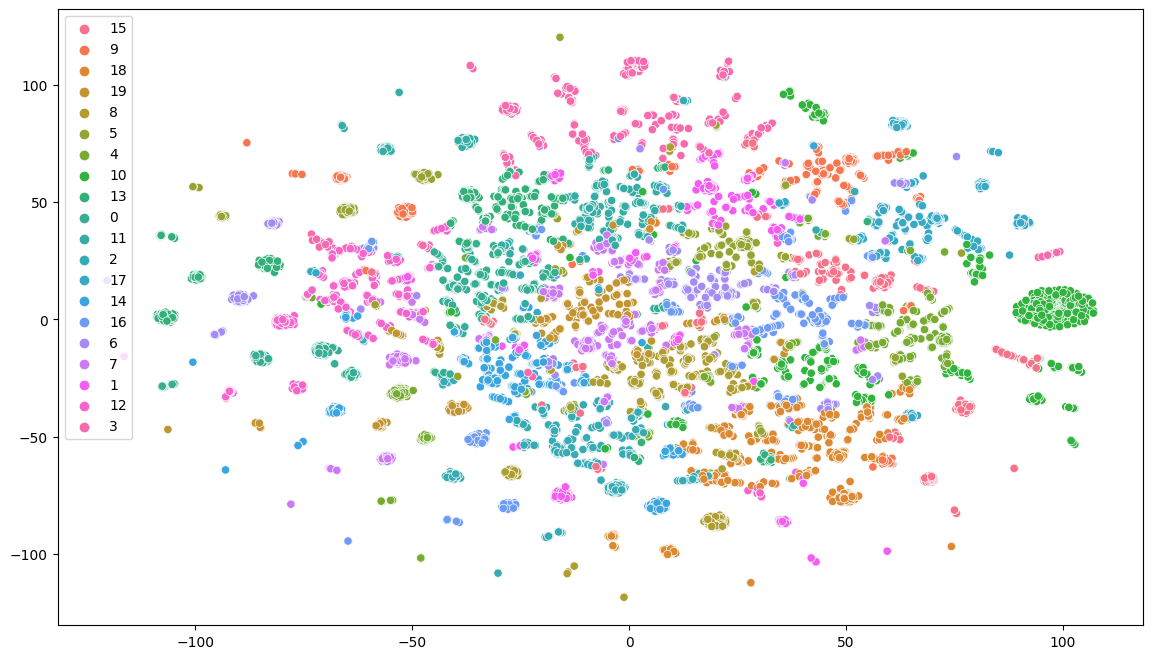

In [25]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x=topics_projected_2d[:, 0], y=topics_projected_2d[:, 1], hue=np.argmax(topics, axis=1).astype(str))

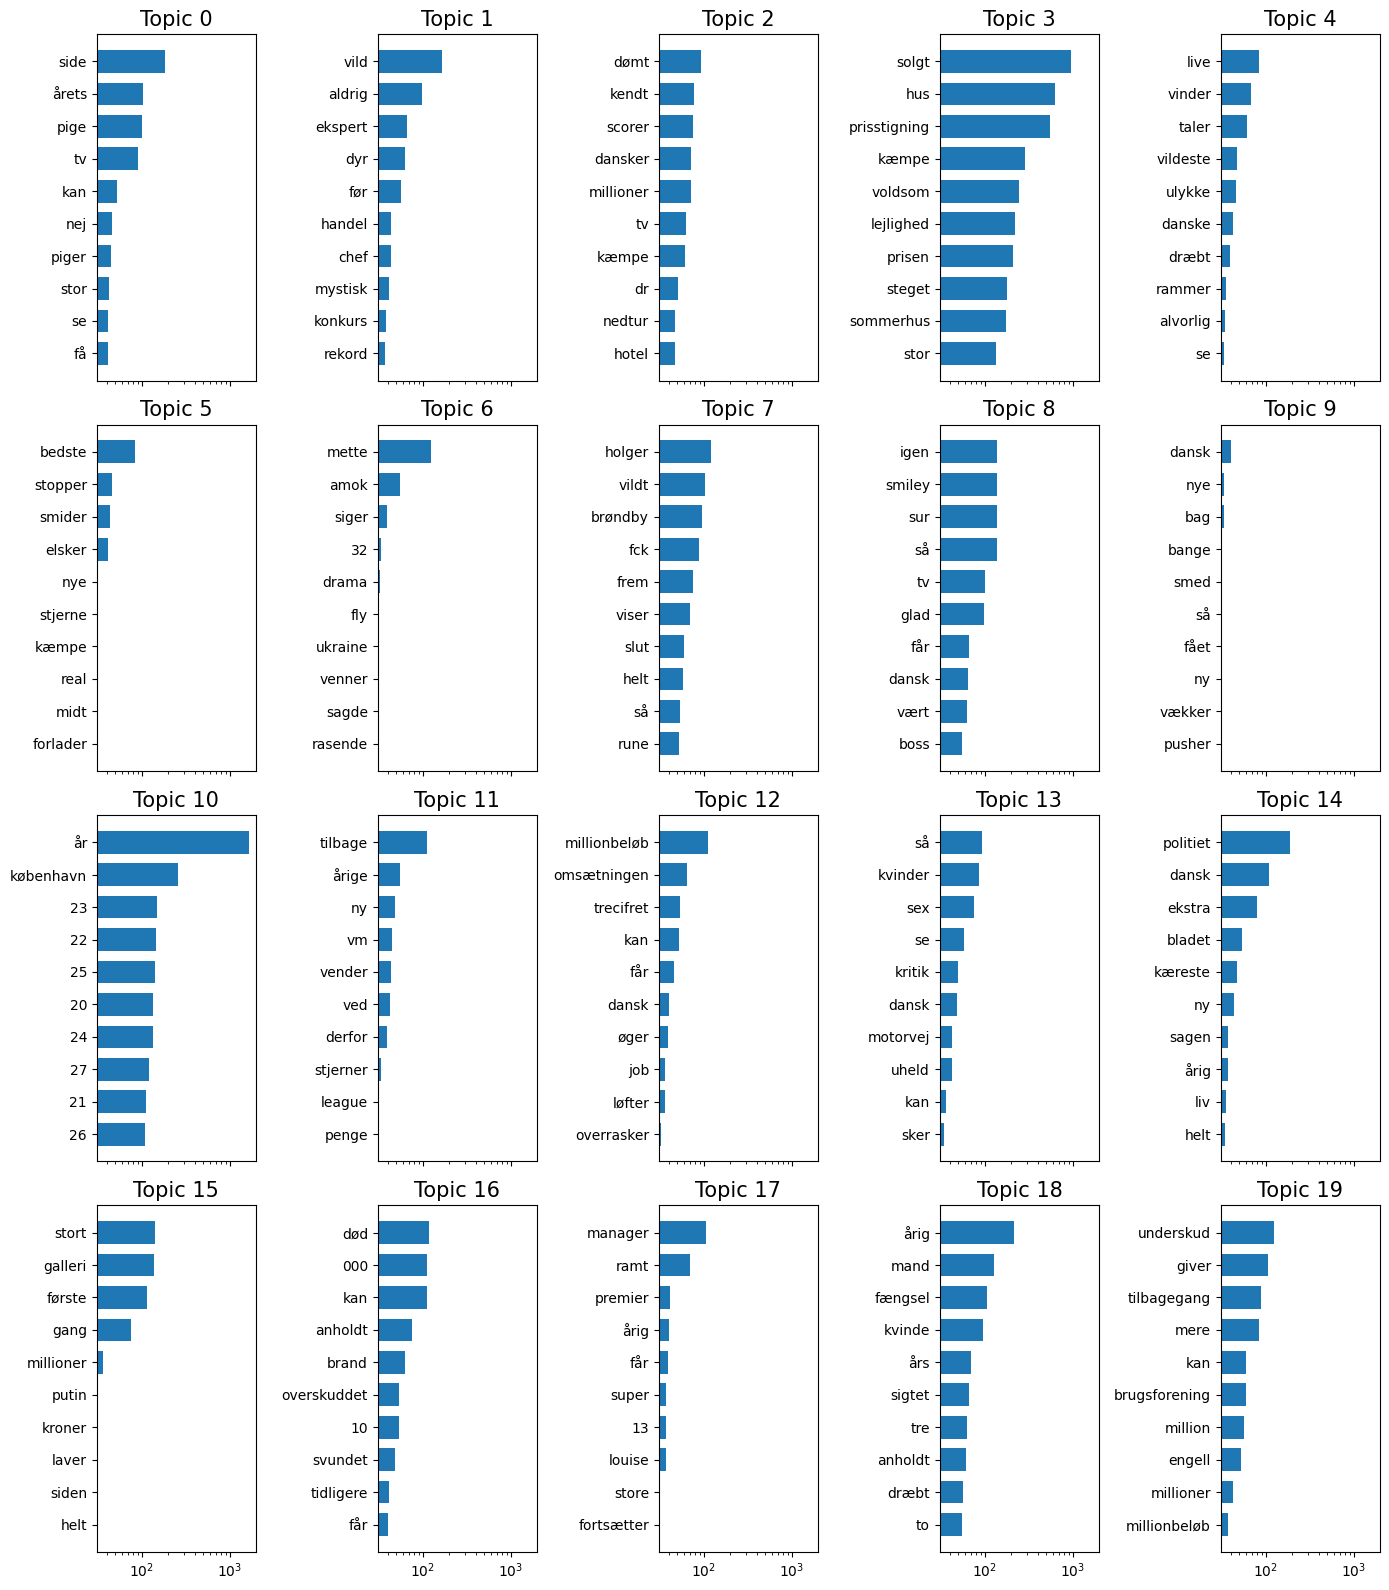

In [26]:
vocab = title_vectorizer.get_feature_names_out()
num_words = 10
cols = 5
rows = int(len(lda_model.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda_model.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

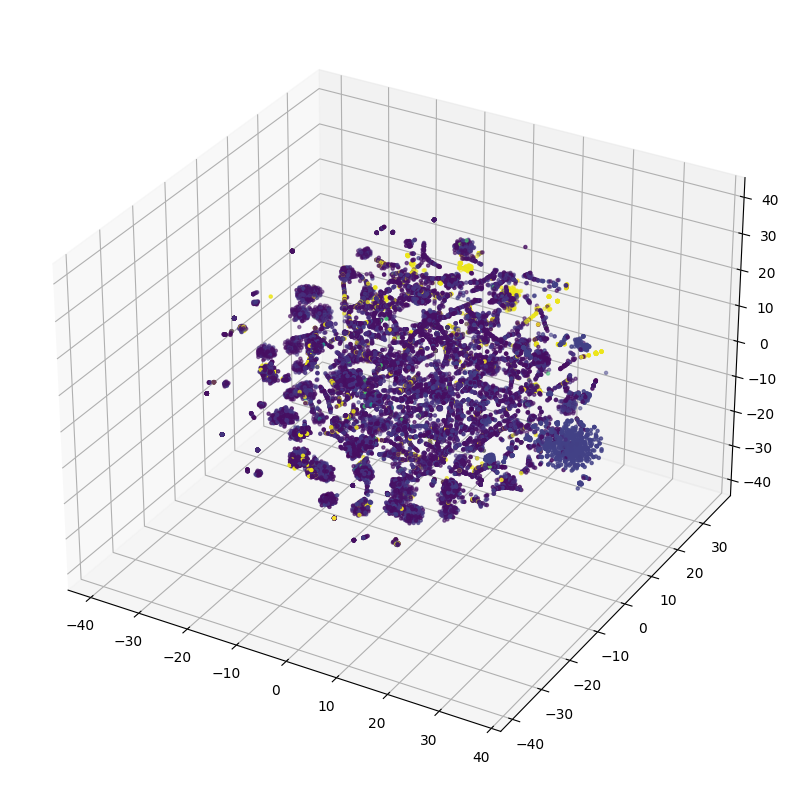

In [27]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topics_projected_3d[:, 0], topics_projected_3d[:, 1], topics_projected_3d[:, 2], c=articles['category'].to_numpy(), marker='.');

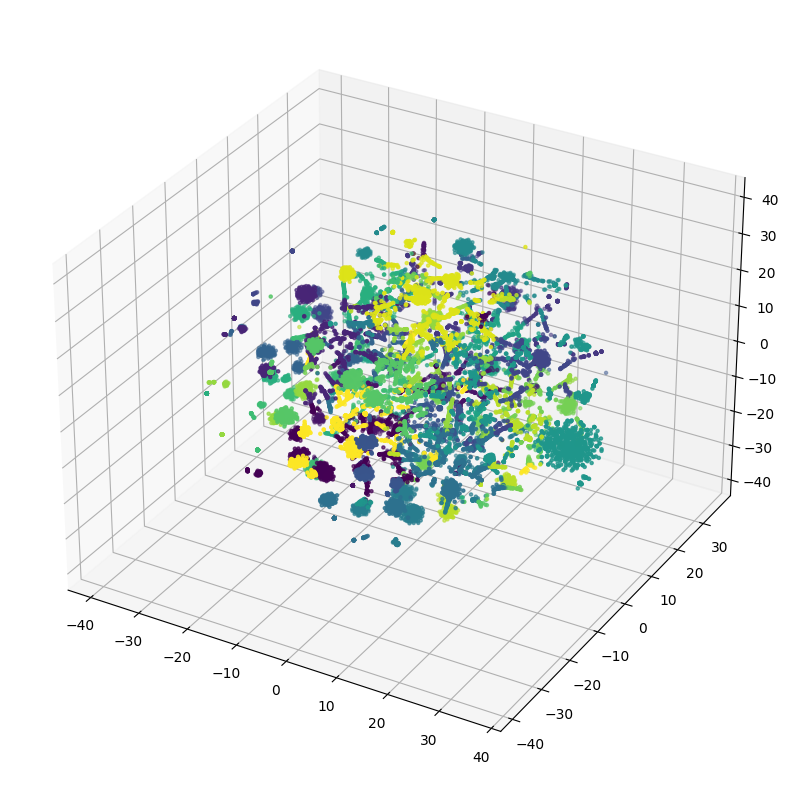

In [28]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topics_projected_3d[:, 0], topics_projected_3d[:, 1], topics_projected_3d[:, 2], c=np.argmax(topics, axis=1).astype(int), marker='.');

## Hyperparameters tuning

In [29]:
import optuna
from sklearn.model_selection import KFold

def perplexity_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 5, 40),
        'doc_topic_prior': trial.suggest_float('doc_topic_prior', 0.01, 1),
        'topic_word_prior': trial.suggest_float('topic_word_prior', 0.01, 1),
        'learning_method': 'online'
    }
    
    perplexities = []
    for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(titles_bow):
        lda_model = LatentDirichletAllocation(**params)
        _ = lda_model.fit_transform(titles_bow[train_idx, :])
        perplexities.append(lda_model.perplexity(titles_bow[test_idx, :]))
        
    return np.mean(perplexities)

In [30]:
study = optuna.create_study(direction='minimize', study_name='lda_tuning')
study.optimize(perplexity_objective, n_trials=50)

[I 2024-04-08 13:53:34,367] A new study created in memory with name: lda_tuning
[I 2024-04-08 13:59:20,360] Trial 0 finished with value: 551375.485632861 and parameters: {'n_components': 36, 'doc_topic_prior': 0.20921749044224927, 'topic_word_prior': 0.49523650191060403}. Best is trial 0 with value: 551375.485632861.
[I 2024-04-08 14:01:55,086] Trial 1 finished with value: 64778.714731968474 and parameters: {'n_components': 6, 'doc_topic_prior': 0.9502695939414836, 'topic_word_prior': 0.7100855470705139}. Best is trial 1 with value: 64778.714731968474.
[I 2024-04-08 14:06:24,365] Trial 2 finished with value: 156684.31792037855 and parameters: {'n_components': 24, 'doc_topic_prior': 0.8805953675445806, 'topic_word_prior': 0.4991068628949864}. Best is trial 1 with value: 64778.714731968474.
[I 2024-04-08 14:11:03,966] Trial 3 finished with value: 4744334.790112732 and parameters: {'n_components': 31, 'doc_topic_prior': 0.29466601324594266, 'topic_word_prior': 0.04326267631814505}. Best i

In [31]:
optuna.visualization.plot_optimization_history(study)

In [32]:
optuna.visualization.plot_slice(study)

In [33]:
optuna.visualization.plot_param_importances(study)

In [34]:
study.best_params

{'n_components': 5,
 'doc_topic_prior': 0.9869012075354201,
 'topic_word_prior': 0.6842817313701199}

In [35]:
lda_model = LatentDirichletAllocation(**study.best_params, learning_method='online')
topics = lda_model.fit_transform(titles_bow)

tsne = TSNE(n_components=2)
topics_projected_2d = tsne.fit_transform(topics)

<Axes: >

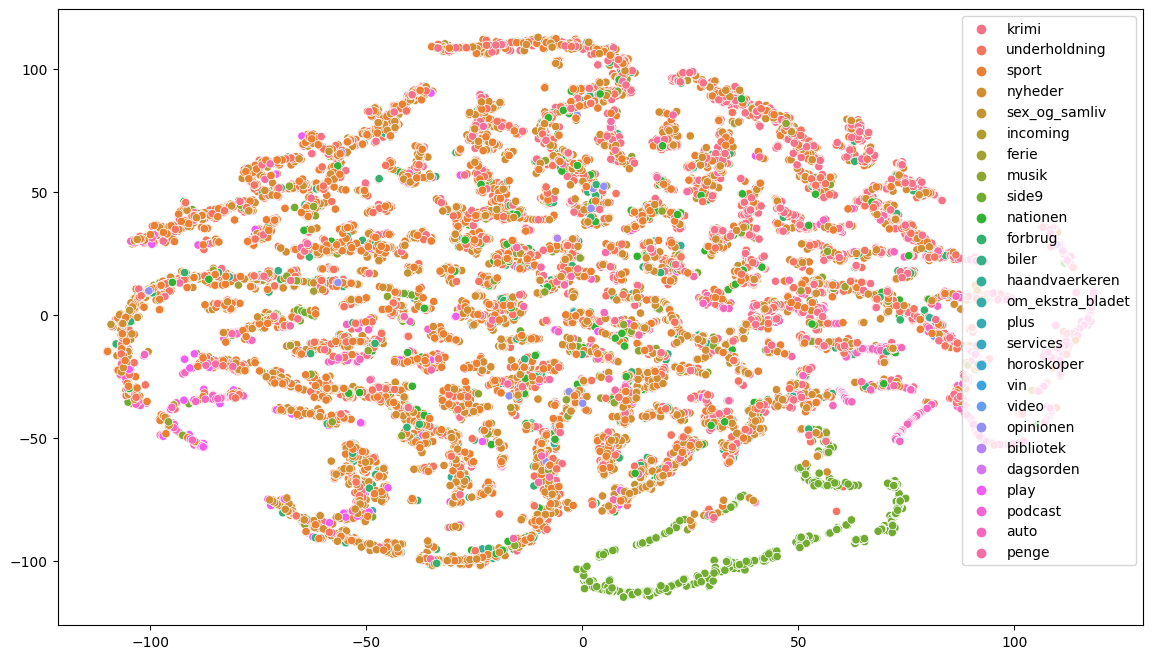

In [36]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.scatterplot(x=topics_projected_2d[:, 0], y=topics_projected_2d[:, 1], hue=articles['category_str'].to_numpy())

<Axes: >

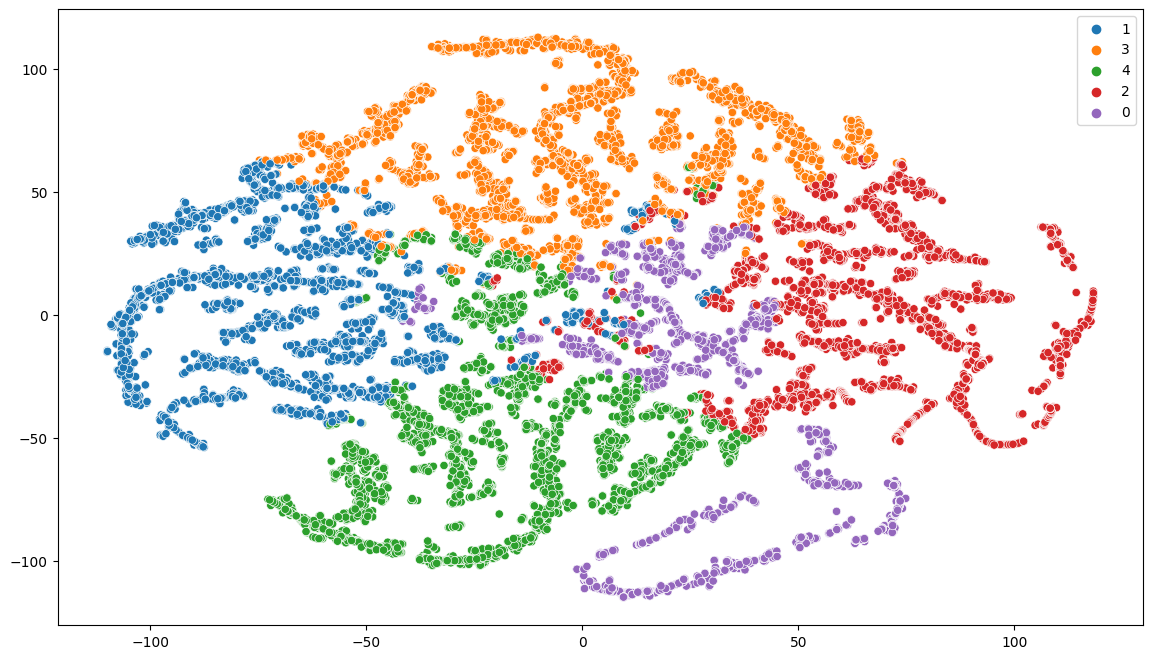

In [37]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x=topics_projected_2d[:, 0], y=topics_projected_2d[:, 1], hue=np.argmax(topics, axis=1).astype(str))

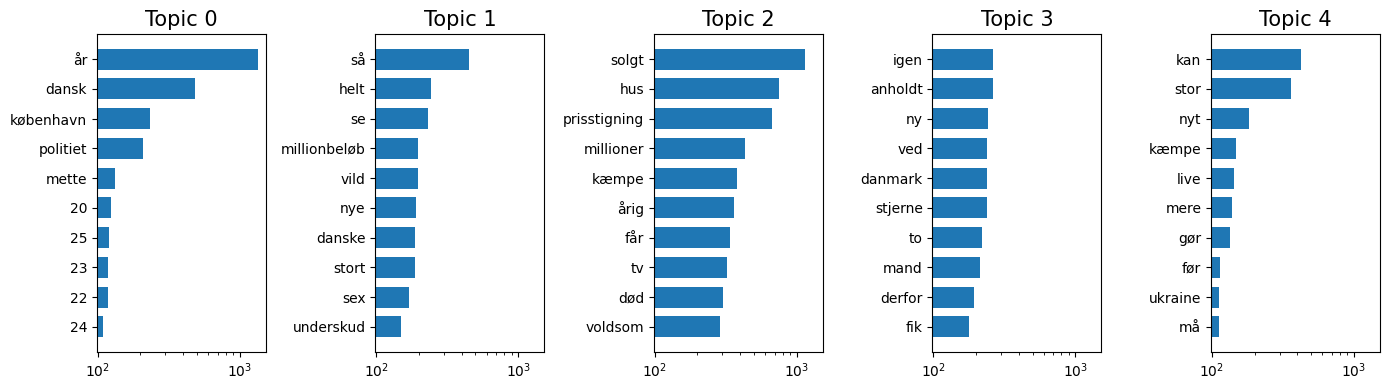

In [38]:
num_words = 10
cols = 5
rows = int(len(lda_model.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda_model.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()